# Spatial Point Pattern Test (SPPT), pre-post crime comparisons

This notebook demonstrates the SPPT, which compares the *relative* changes in crime composition. E.g. prior historical an area had 5%, and in the post period has 10%, is that difference statistically significant? Uses Chi-square tests and false discovery rate correction to correct for multiple testing.

Wheeler, A. P., Steenbeek, W., & Andresen, M. A. (2018). Testing for similarity in area‐based spatial patterns: Alternative methods to Andresen's spatial point pattern test. [*Transactions in GIS*, 22(3), 760-774](https://onlinelibrary.wiley.com/doi/abs/10.1111/tgis.12341). [Preprint](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3111822)

In [1]:
from crimepy import query, sppt, geo, query
from crimepy.cdcplot import plt
import pandas as pd

# where I am getting the example data from, Durham crimes and Durham boundary
local_proj = 'EPSG:2264'
crime_url = 'https://www.arcgis.com/sharing/rest/content/items/a12d5115aac040a99ff89de1ba26eb07/data'
geo_url = 'https://webgis2.durhamnc.gov/server/rest/services/PublicServices/Administrative/MapServer/1/query'
geo_kwargs = {'f': 'geojson', 'outFields': '*', 'outSR': local_proj[-4:], 'where': '1=1'}

# these are my caching functions to grab data online once
# load in Durham data
crime = query.cache(crime_url,'DurhamCrime.csv.zip',filetype='.xlsx')
bound = query.query_esri(geo_url,params=geo_kwargs)

# convert crime and calls to geopandas
crime = geo.convgpd(crime,['X','Y'],local_proj)

crime.head()

,Case Number,Report Date,Report Time,Status,Sequence,ATT/COM,UCR Code,Offense,Address,X,Y,District,Beat,Tract,Premise,Weapon,geometry
0,18009733,10/18/2018,2:35:00PM,Inactive,1,COM,35A,DRUG/NARCOTIC VIOLATIONS,800 DUPREE ST,2.030964e+06,810554.959469,D4,411,1301.0,Home Of Offender - Single Family,Not Applicable/None,POINT (2030964.045 810554.959)
1,18009733,10/18/2018,2:35:00PM,Inactive,2,COM,35B,DRUG EQUIPMENT/PARAPHERNALIA,800 DUPREE ST,2.030953e+06,810652.912119,D4,411,1301.0,Home Of Offender - Single Family,Not Applicable/None,POINT (2030952.776 810652.912)
2,18011362,11/19/2018,12:00:00PM,Cleared By Arrest,1,COM,35A,DRUG/NARCOTIC VIOLATIONS,300 JUNCTION RD,2.043312e+06,816593.088037,D1,123,1802.0,Parking/Drop Lot/Garage,Not Applicable/None,POINT (2043311.524 816593.088)
3,18014707,2/19/2019,5:28:00PM,Cleared By Arrest,1,COM,35A,DRUG/NARCOTIC VIOLATIONS,3600 DANUBE LN,2.033370e+06,833430.188349,D2,223,1709.0,Home Of Offender - Single Family,(blank),POINT (2033370.001 833430.188)
4,18018337,11/20/2018,5:00:00PM,Cleared By Arrest,1,COM,35A,DRUG/NARCOTIC VIOLATIONS,300 JUNCTION RD,2.043288e+06,816466.481070,D1,123,1802.0,Parking/Drop Lot/Garage,Unknown/Not Stated,POINT (2043288.249 816466.481)


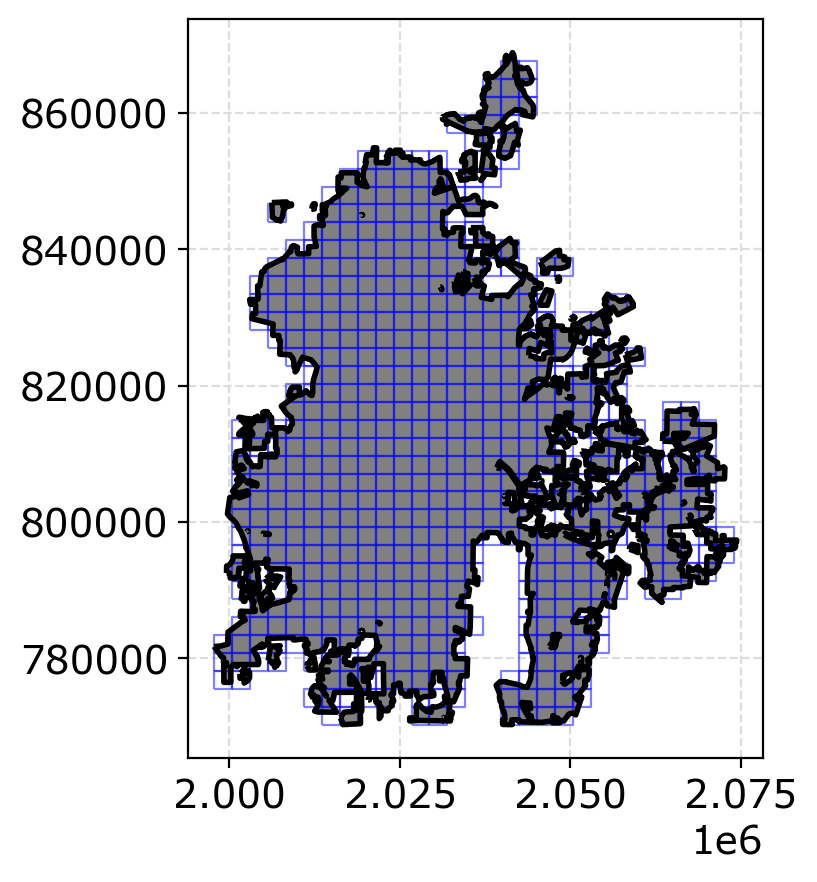

In [2]:
# For the SPPT, need to have areas defined
# here I make a regular grid over the study area
# see https://andrewpwheeler.com/2021/07/03/spatial-sample-size-suggestions-for-sppt-analysis/
# for how to estimate the size of the grid based on your total points

# create regular grid over study area
# quarter mile areas, size is the size of a side
grid = geo.grid_over(bound,5260/2,percent=0.2)

ax = bound.plot(color='grey',linewidth=3)
grid.boundary.plot(color='blue',ax=ax,alpha=0.5,linewidth=0.8)
bound.boundary.plot(color='k',ax=ax,linewidth=2)

# assign points to grid
crime = geo.pip(crime,grid,keep=['index'])
crime['Report Date'] = pd.to_datetime(crime['Report Date'])

,Old_MVL,New_MVL,PropC1,PropC2,Dif,p,q
29,42,30,0.003010,0.009231,0.006221,1.616077e-06,1.176148e-03
61,10,12,0.000717,0.003692,0.002976,6.272142e-05,2.535966e-02
78,1,19,0.000072,0.005846,0.005774,3.950509e-17,7.187754e-14
82,43,29,0.003082,0.008923,0.005841,6.969407e-06,4.226829e-03
92,9,11,0.000645,0.003385,0.002740,1.221198e-04,3.703181e-02
95,0,5,0.000000,0.001538,0.001538,4.854684e-05,2.208214e-02
113,6,16,0.000430,0.004923,0.004493,6.316436e-10,5.746220e-07
120,7,10,0.000502,0.003077,0.002575,9.694057e-05,3.463213e-02
183,103,90,0.007382,0.027692,0.020310,1.037903e-22,3.776824e-19
239,8,19,0.000573,0.005846,0.005273,4.318238e-11,5.237878e-08


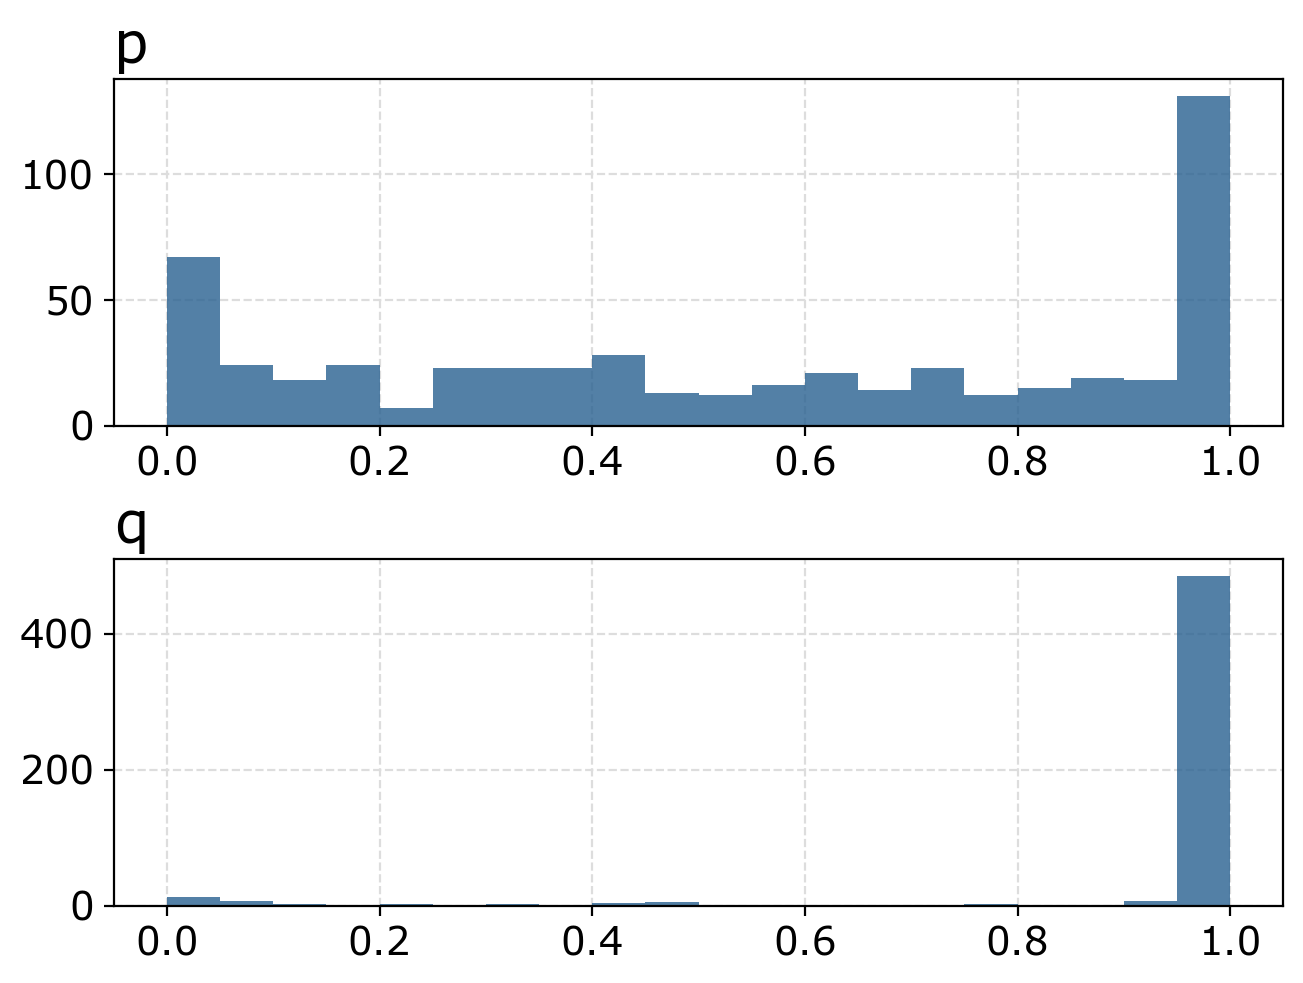

In [3]:
# compare old motor vehicle thefts to new
mvl = crime[crime['Offense'] == 'LARCENY - FROM MOTOR VEHICLE'].copy()
mvl['Old_MVL'] = 1*((mvl['Report Date'].dt.year > 2018) & (mvl['Report Date'].dt.year < 2024))
mvl['New_MVL'] = 1*(mvl['Report Date'].dt.year >= 2024)
mvl_stats = mvl.groupby('index',as_index=False)[['Old_MVL','New_MVL']].sum()
grid_mv = grid.merge(mvl_stats,on=['index'],how='inner')
spres = sppt.sppt(grid_mv,'Old_MVL','New_MVL')
grid_mv.loc[spres.index,list(spres)] = spres

# Can see how the false discovery rate changes the results
fig, axs = plt.subplots(2,layout='constrained')
axs = spres[['p','q']].hist(bins=20, alpha=0.8, ax=axs)

# These are places highlighted as different
spres[spres['q'] < 0.05]

In [4]:
# These are places where crime *decreased*
# divide Old_MVL by 5 to get normalized
# counts per time, no stat significant decreases though
# when using false discovery rate correction
spres.sort_values(by='Dif').head(20)

,Old_MVL,New_MVL,PropC1,PropC2,Dif,p,q
346,123,9,0.008815,0.002769,-0.006046,0.000569,0.109042
329,181,26,0.012972,0.008000,-0.004972,0.024322,1.000000
379,142,17,0.010177,0.005231,-0.004946,0.010709,0.906292
400,80,4,0.005734,0.001231,-0.004503,0.001489,0.225796
325,199,32,0.014262,0.009846,-0.004416,0.059396,1.000000
362,121,14,0.008672,0.004308,-0.004364,0.015139,1.000000
381,112,12,0.008027,0.003692,-0.004335,0.011880,0.939803
454,120,15,0.008600,0.004615,-0.003985,0.027223,1.000000
208,81,6,0.005805,0.001846,-0.003959,0.006367,0.626184
327,182,30,0.013044,0.009231,-0.003813,0.091757,1.000000


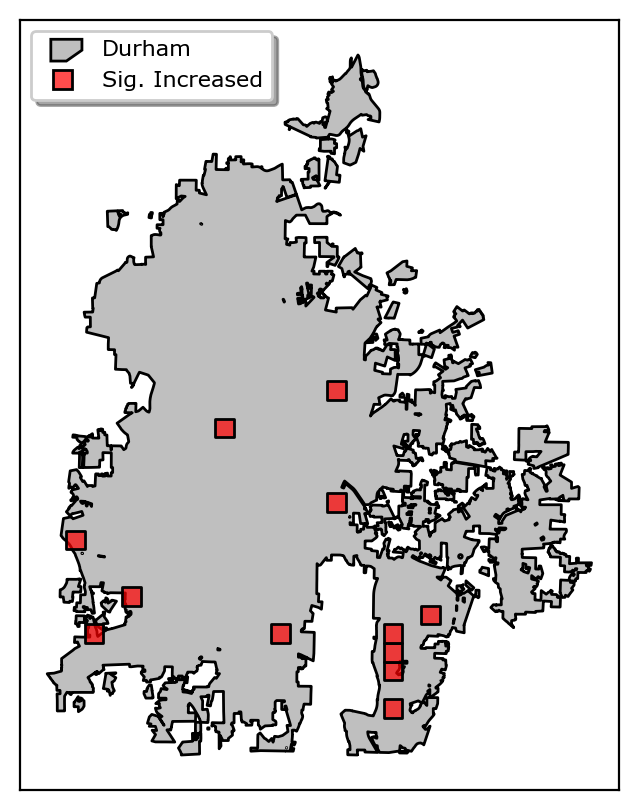

In [5]:
# lets make a nice map of the differences
sig_areas = grid_mv[grid_mv['q'] < 0.05]

# helpers for geo maps
fig, ax = plt.subplots(figsize=(5,5))

hm = {}
bn, bh = geo.geo_map(bound,ax,fill='grey',fill_alpha=0.5)
hn, hh = geo.geo_map(sig_areas,ax,fill='red',fill_alpha=0.7,leg_type='GridArea')
hm[bn] = bh
hm[hn] = hh

ax.legend(hm.keys(),['Durham','Sig. Increased'],handler_map=hm, loc='upper left',fontsize=8)
xticks = ax.get_xaxis().set_ticks([])
yticks = ax.get_yaxis().set_ticks([])



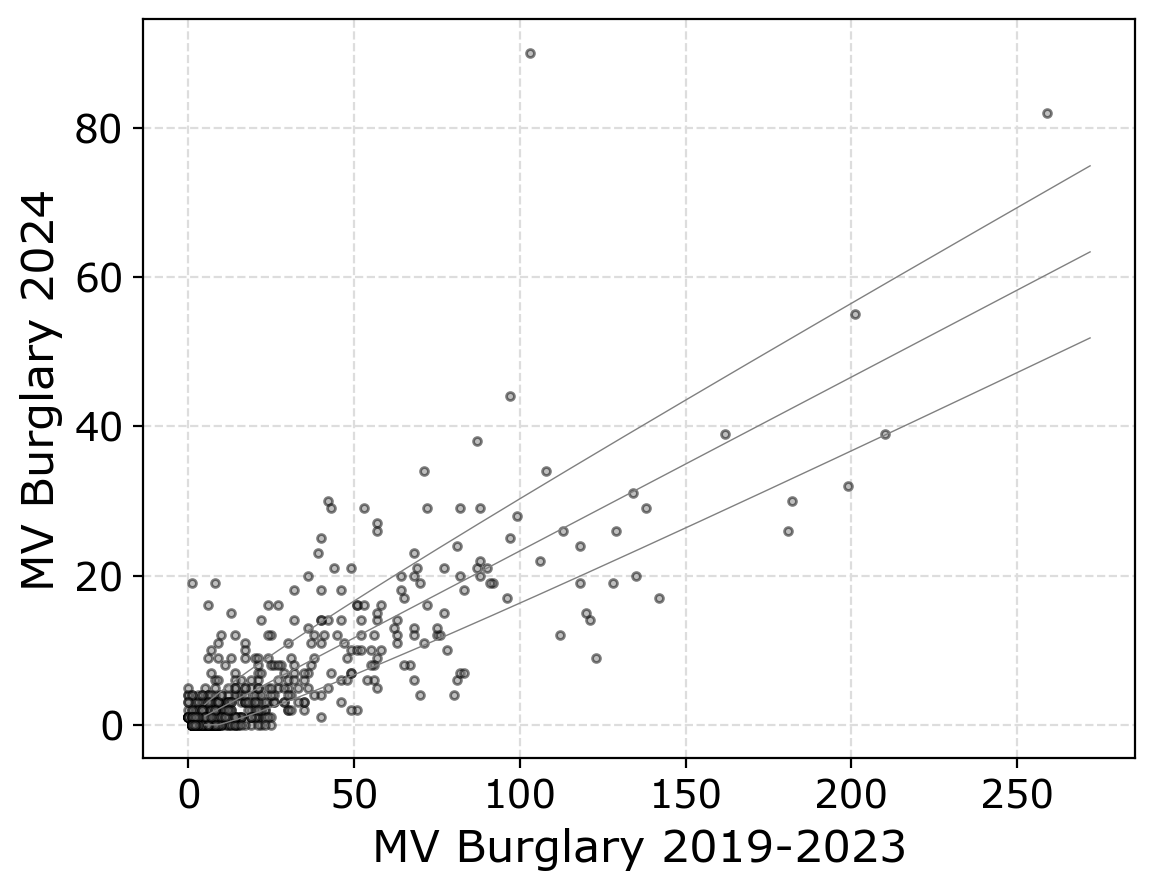

In [6]:
# Comparing pre-counts to post counts is another way
# this uses Poisson approximation to draw lines on a scatterplot

cont_lines = sppt.pois_contour(spres,'Old_MVL','New_MVL')

# More variance than you would expect with just Poisson
ax = spres.plot.scatter('Old_MVL','New_MVL',color='grey',s=8,edgecolor='k',alpha=0.5)
ax = cont_lines.plot(color='grey',legend=False,ax=ax,lw=0.5)
txt = ax.set_ylabel('MV Burglary 2024')
txt = ax.set_xlabel('MV Burglary 2019-2023')
